In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
from theano import function, config, shared, tensor
import pymc3 as pm
import arviz as az

In [19]:
%matplotlib inline

In [20]:
df = pd.read_csv('./BattingAverage.csv')
df.describe()

,Hits,AtBats,PlayerNumber,PriPosNumber
count,948.000000,948.000000,948.000000,948.000000
mean,44.303797,173.972574,474.500000,3.809072
std,54.523418,196.694901,273.808327,2.757431
min,0.000000,1.000000,1.000000,1.000000
25%,1.000000,9.000000,237.750000,1.000000
50%,17.000000,78.000000,474.500000,3.000000
75%,75.000000,300.250000,711.250000,6.000000
max,216.000000,683.000000,948.000000,9.000000


In [21]:
num_players = len(df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_player, concentration_players, μ_players]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:27<00:00, 358.80draws/s]


                         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
μ_players               0.238  0.002   0.234    0.242      0.000    0.000   
concentration_players  77.767  5.432  67.950   88.319      0.104    0.074   
θ_player[0]             0.230  0.045   0.143    0.312      0.000    0.000   
θ_player[1]             0.241  0.024   0.195    0.285      0.000    0.000   
θ_player[2]             0.247  0.036   0.184    0.318      0.000    0.000   
...                       ...    ...     ...      ...        ...      ...   
θ_player[943]           0.238  0.047   0.154    0.325      0.000    0.000   
θ_player[944]           0.277  0.017   0.244    0.309      0.000    0.000   
θ_player[945]           0.218  0.036   0.153    0.284      0.000    0.000   
θ_player[946]           0.172  0.033   0.112    0.235      0.000    0.000   
θ_player[947]           0.266  0.017   0.233    0.298      0.000    0.000   

                       ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
μ_pla

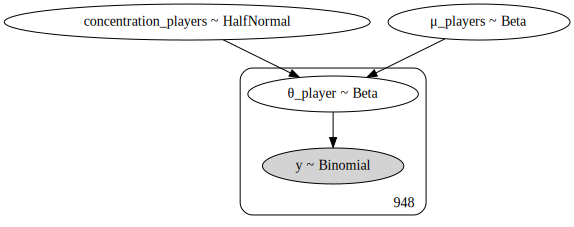

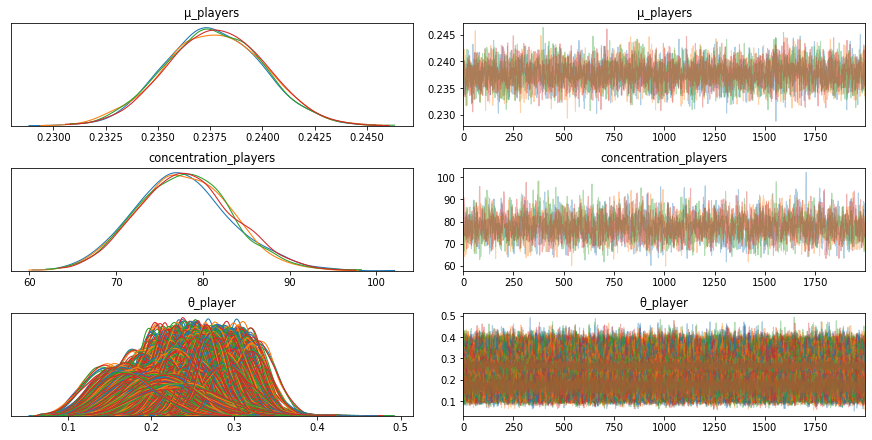

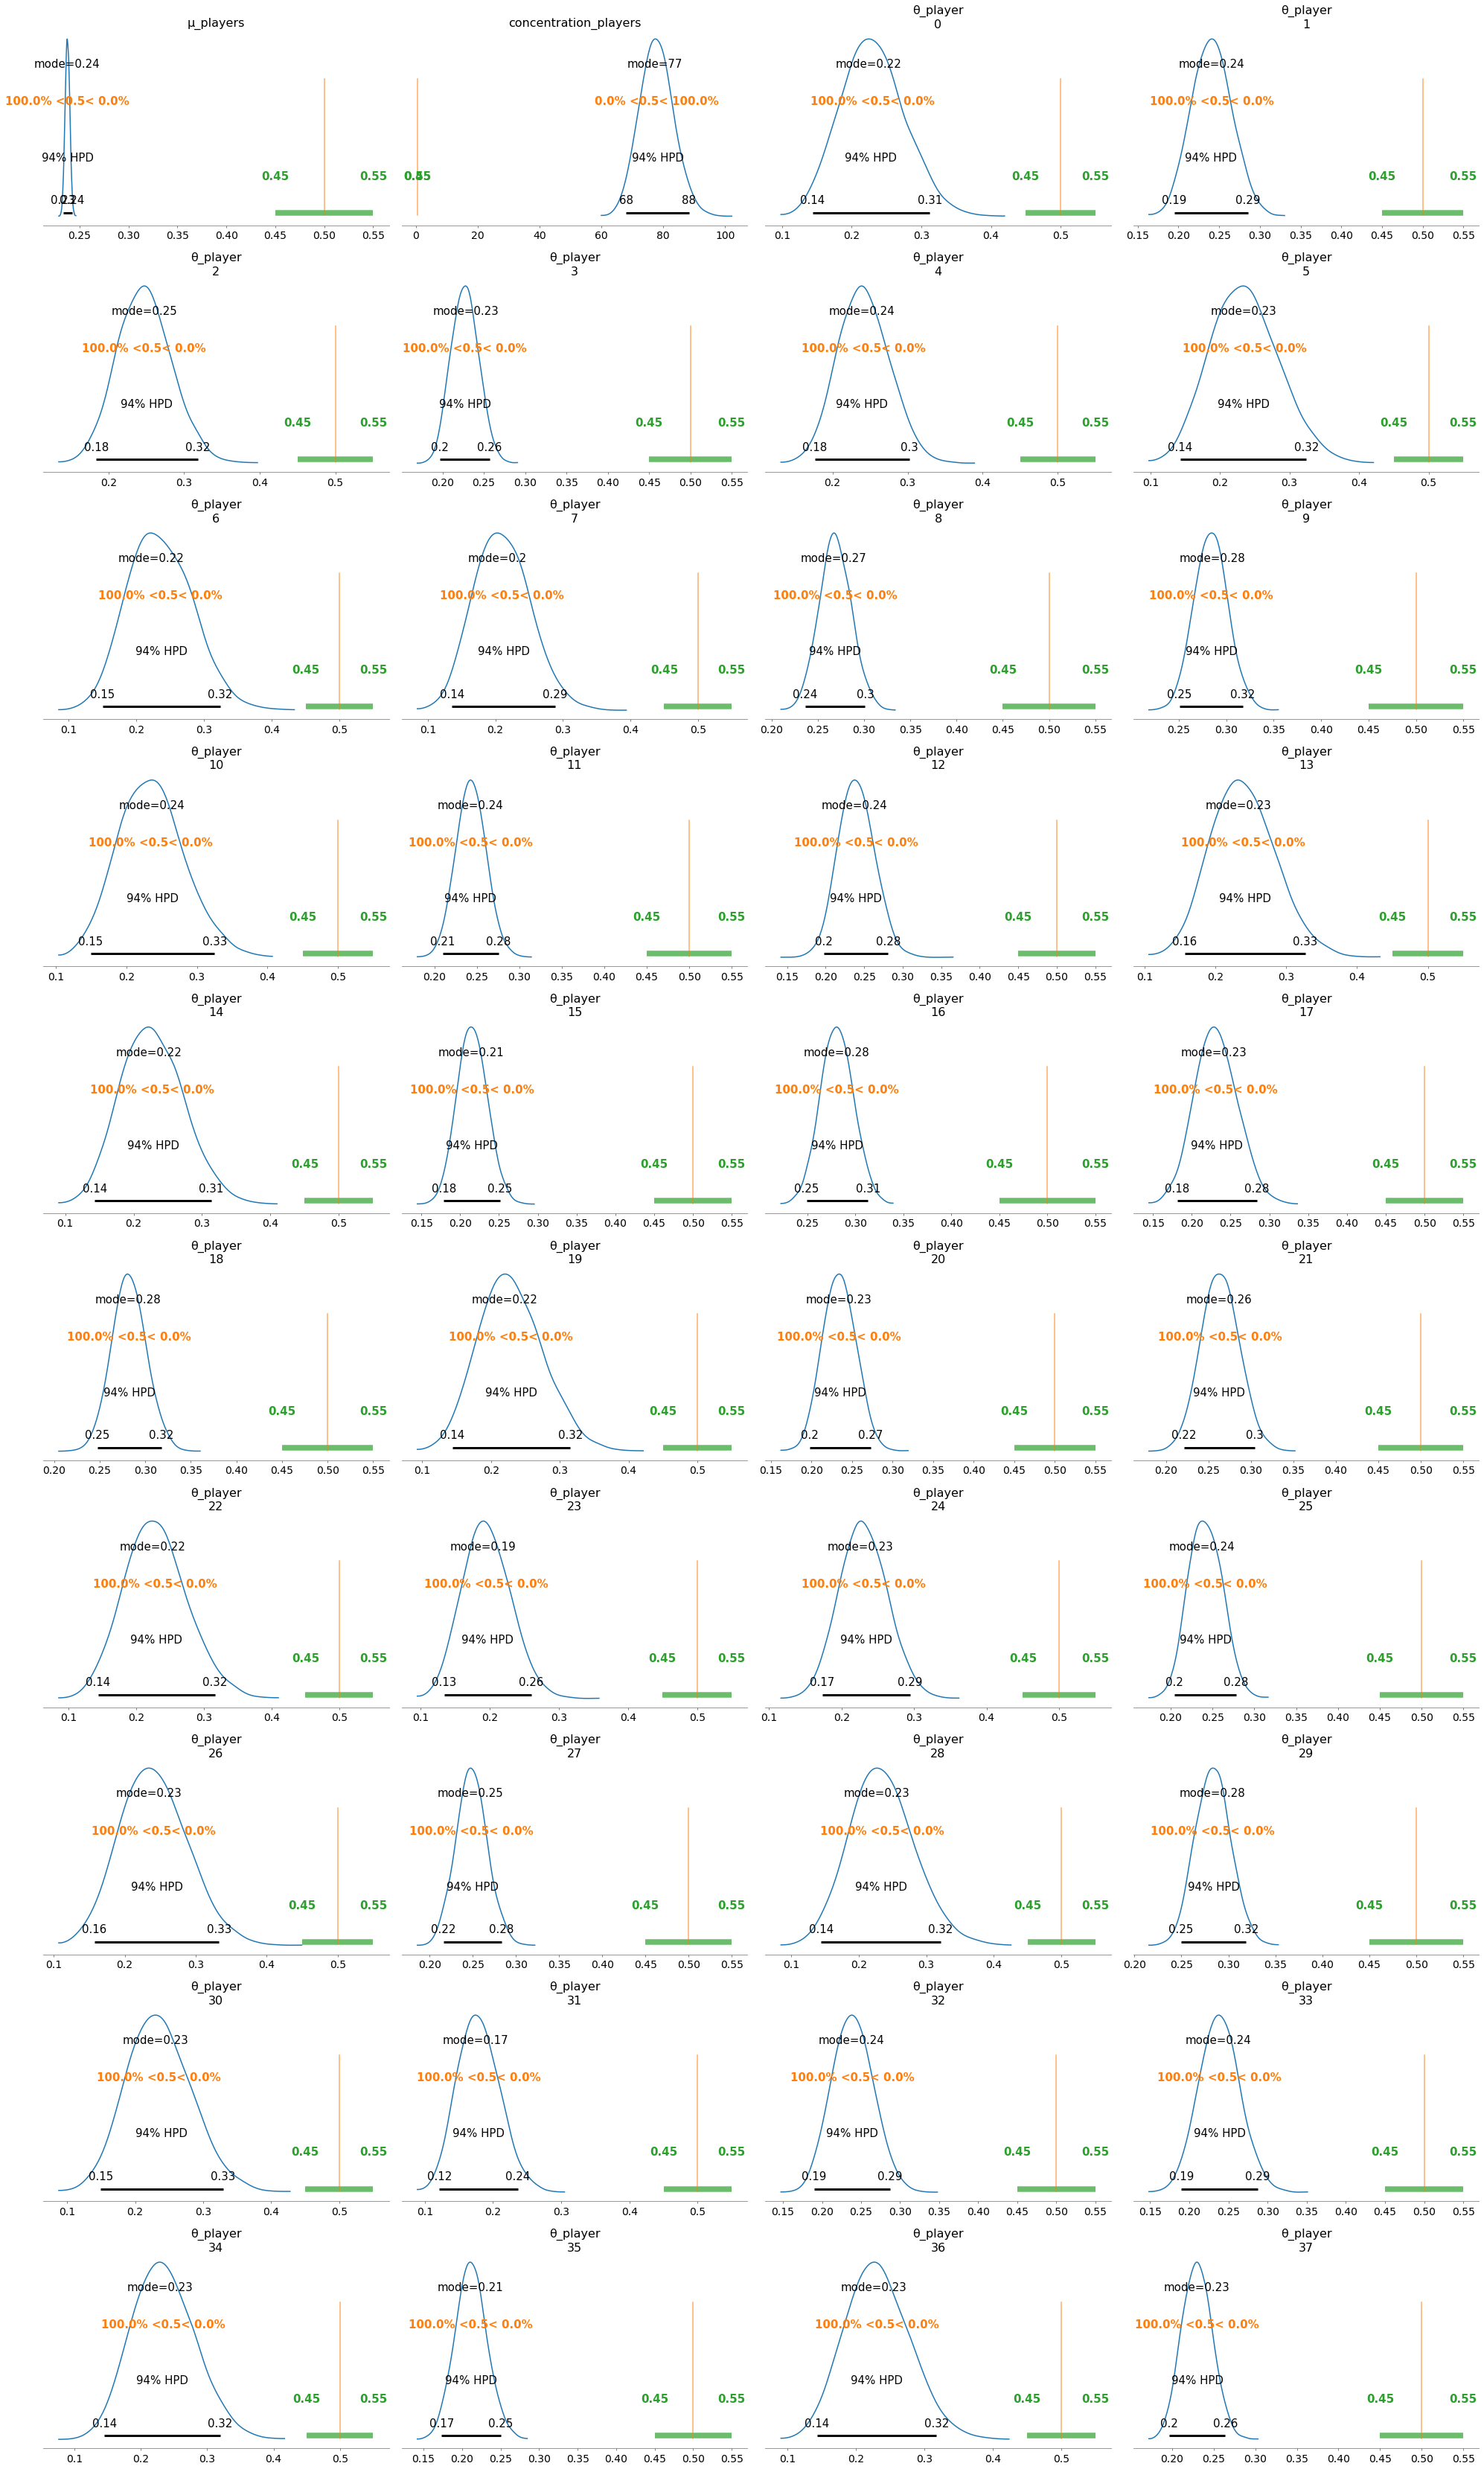

In [22]:
with pm.Model() as model_nh:
    μ_players = pm.Beta('μ_players', 1, 1)
    concentration_players = pm.HalfNormal('concentration_players', 10)

    θ_player = pm.Beta('θ_player',
                       alpha=μ_players*concentration_players,
                       beta=(1.0-μ_players)*concentration_players,
                       shape=num_players)
    y = pm.Binomial('y', n=df['AtBats'], p=θ_player, observed=df['Hits'])

    trace = pm.sample(2000, random_seed=123)
    print(az.summary(trace))
    pm.traceplot(trace)
    az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_nh)


ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/ctarrington/anaconda3/envs/try-tensorflow2/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/ctarrington/anaconda3/envs/try-tensorflow2/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/ctarrington/anaconda3/envs/try-tensorflow2/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'Could not load "libnvrtc.so": libnvrtc.so: cannot open shared object file: No such file or directory'


[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 1.812843 seconds
Result is [1.23178032 1.61879341 1.52278065 ... 2.20771815 2.29967753 1.62323285]
Used the cpu
